______________

# **TECH CHALLENGE - MODELO PREDITIVO COM DADOS DA IBOVESPA**
_______

# **Integrantes do Grupo**
| Nome | E-mail | Linkedin | RM|
| -----| -------| ---------| -------|
|Alice Falconi Teodoro | arquiteta-angelica@hotmail.com |www.linkedin.com/in/alice-falconi-434292248/| 353137 |
|Iago Coelho dos Santos | iagocoelhos@gmail.com |www.linkedin.com/in/iago-coelho/ | 353528 |
|João Vitor Lima Nogueira Pereira | contatojoaopereira1@gmail.com| www.linkedin.com/in/joao-nogueiraa/| 353977|
|Leonardo Galdino Sertão | leonardogaldinno@gmail.com |www.linkedin.com/in/leonardo-galdino-8940a5121/| 354029 |

# **Introdução**

<div style="text-align: justify;">
<p style="font-size: 17px;">No cenário atual de volatilidade econômica, a capacidade de prever movimentos do mercado tornou-se uma ferramenta valiosa para investidores e analistas financeiros. Este trabalho propõe o desenvolvimento de um modelo preditivo robusto para a série temporal da IBOVESPA, o principal indice da bolsa de valores do Brasil. Através de técnicas avançadas de Machine Learning e análise de dados, buscamos não apenas entender as tendências passadas, mas também prever com precisão o fechamento diário do índice.</p>

<p style="font-size: 17px;">A jornada deste projeto se inicia com captura de dados históricos, passando pela limpeza e preparação destes, até a modelagem preditiva e validação do modelo. A técnica escolhida será justificada com base em sua eficácia, garantindo que o modelo seja praticamente aplicável.</p>

<p style="font-size: 17px;">O objetivo é alcançar uma acurácia superior a 70%, o que indica um modelo altamente confiável dentro do contexto de previsões financeiras.
A acurácia não apenas reflete a robustez do modelo, mas também assegura uma ferramenta de apoio decisivo para estratégias de investimento no mercado de ações brasileiro.
</div></p>

# **Desenvolvimento**

## **1. Importação de Dados e Bibliotecas**

<div style="text-align: justify;">
<p style="font-size: 17px;">Decidimos utilizar a biblioteca yFinance para importar os dados da IBOVESPA.</p>
<p style="font-size: 17px;">A yFinance oferece uma maneira fácil de acessar dados históricos de mercado de ações, tornando a pesquisa e o desenvolvimento de modelos preditivos mais acessíveis. Além disso, é conhecida por sua simplicidade e facilidade de uso. Com apenas algumas linhas de código, podemos extrair uma grande variedade de dados financeiros, facilitando a implementação e o teste de diferentes modelos preditivos.</p>
<p style="font-size: 17px;">Por fim, a capacidade de acessar dados atualizados em tempo real é importamte para a construção de modelos preditivos precisos em um mercado volátil como o de ações, permitindo ajustes e melhorias contínuas com base nas condições de mercado mais recentes. Essas características fundamentam nossa escolha pela biblioteca yFinance, visando o desenvolvimento de modelos robustos e precisos para a previsão dos pontos de fechamento do mercado de ações no Brasil.</p>
</div>

In [ ]:
!pip install statsforecast

In [ ]:
import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
import statsmodels.api as sm

from prophet import Prophet
from sklearn.metrics import (classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score)
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, ARIMA, Naive, SeasonalNaive,
                                  SeasonalWindowAverage)
from statsforecast.utils import ConformalIntervals
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<div style="text-align: justify;">
<p style="font-size: 17px;">Com o objetivo de não enviesar nossa base de dados com históricos de crises financeiras como as ocorridas em 2008 e 2015, e a crise sanitária em 2020, optamos por importar uma base considerando os últimos 3 anos. De acordo com nossas análises e testes realizados, verificamos que as oscilações da bolsa de valores nos períodos de crise são significativamente maiores em comparação aos demais períodos. Essas oscilações criam outliers na nossa base de dados, o que pode gerar problemas para nossos modelos durante a criação de predições.</p></div>

In [ ]:
start_date = '2021-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')

df = yf.download('^BVSP', start=start_date, end=end_date)

df.tail()

[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2024-07-22  127616.0  128151.0  127456.0  127860.0   127860.0  6098200
2024-07-23  127860.0  127860.0  126530.0  126590.0   126590.0  7022900
2024-07-24  126596.0  126823.0  126218.0  126423.0   126423.0  7304800
2024-07-25  126423.0  126423.0  125626.0  125954.0   125954.0  7134100
2024-07-26  125964.0  127700.0  125953.0  127492.0   127492.0  8272000

## **2. Tratamento dos Dados**


<div style="text-align: justify;">
<p style="font-size: 17px;">Como a bolsa de valores opera apenas em dias úteis, os dados da nossa base não estão em uma frequência diária. Por isso, utilizamos a função 'asfreq' para adicionar uma frequência diária à base. Essa função cria os dias faltantes, mas com valores nulos.</p>

<p style="font-size: 17px;">Usamos a função 'fillna' com o método 'ffill' para substituir os valores nulos pelo valor anterior mais próximo. Por exemplo, os valores do fim de semana seriam preenchidos com os dados da sexta-feira.</p>

<p style="font-size: 17px;">É essencial adicionar uma frequência diária à base, pois isso assegura o funcionamento dos modelos, já que eles fazem previsões em dias consecutivos. Garantir uma base com dados diários também é importante para evitar qualquer tipo de problema durante a avaliação dos erros e da precisão dos modelos.</p>
</div>

In [ ]:
df = df.asfreq('D')
df = df.fillna(method='ffill')

<div style="text-align: justify;">
<p style="font-size: 17px;">Nas linhas de comando a seguir, estamos criando um novo DataFrame chamado 'df_model' com base nos nossos dados importados do yFinance, onde manteremos nossas datas e nossa variável alvo. Além disso, estamos alterando os nomes das nossas colunas para estarem de acordo com o padrão esperado pela maioria dos modelos de predição em Python.</p>
</div>

In [ ]:
df_model = df[['Close']].copy()
df_model.reset_index(inplace=True)
df_model = df_model.rename(columns={'Date':'ds', 'Close':'y'})
df_model['unique_id'] = 'IBOVESPA'
last_date = df_model['ds'].max()
df_model.head(2)

ds         y unique_id
0 2021-01-04  118558.0  IBOVESPA
1 2021-01-05  119223.0  IBOVESPA

<div style="text-align: justify;">
<p style="font-size: 17px;">Nossa base df_model está pronta e possui os padrões necessários para realizar testes em modelos. A seguir, verificaremos se a nossa série temporal é estacionária ou não.</p>

<p style="font-size: 17px;">Estacionaridade em uma série temporal significa que suas propriedades estatísticas, como média e variância, são constantes ao longo do tempo. Em outras palavras, o comportamento da série não muda com o tempo.</p>

<p style="font-size: 17px;">Alguns modelos de aprendizado de máquina necessitam que os dados estejam estacionários para o seu funcionamento, pois não se adequam às sazonalidades e ruídos da série temporal e podem ter problemas ao gerar predições. Dessa forma, se a nossa série temporal não estiver estacionária, criaremos uma base separada onde deixaremos os dados estacionários para utilização em modelos específicos, como o ARIMA.</p>

</div>

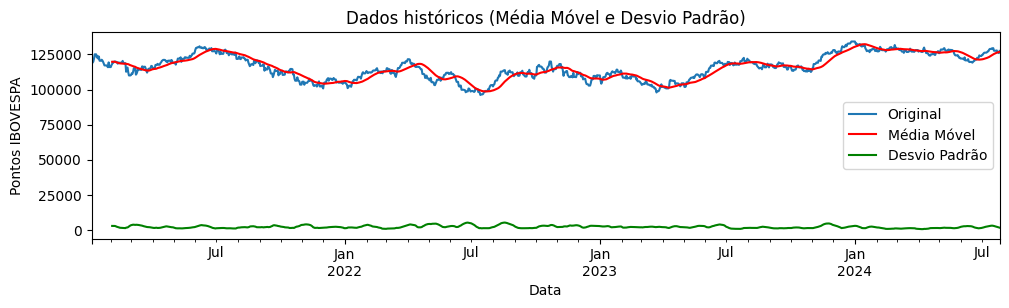

In [ ]:
ma = df.Close.rolling(30).mean()
st = df.Close.rolling(30).std()

f,ax = plt.subplots(figsize = (10,3))
df.Close.plot(ax=ax, legend=False, label='Original')
ma.plot(ax=ax, legend=False, color='r', label='Média Móvel')
st.plot(ax=ax, legend=False, color='g', label='Desvio Padrão')
plt.tight_layout()
plt.title('Dados históricos (Média Móvel e Desvio Padrão)')
plt.ylabel('Pontos IBOVESPA', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.legend()
plt.show()

<div style="text-align: justify;">
<p style="font-size: 17px;">
No gráfico acima, observamos que a média móvel apresenta uma tendência, enquanto o desvio padrão permanece relativamente constante ao longo do tempo. Para que nossa série temporal seja considerada estacionária, é necessário que ambas as estatísticas não apresentem tendências.
<p style="font-size: 17px;">
Neste caso, podemos dizer que nossa série temporal atualmente não é estacionária. Porém, para comprovar estatisticamente que nossa série temporal não é estacionária, vamos utilizar um método científico chamado Augmented Dickey-Fuller (ADF).
<p style="font-size: 17px;">
O teste ADF nos permite verificar se há uma tendência significativa na série temporal através de um teste de hipótese.
<p style="font-size: 17px;">
As hipóteses são:
<ul class="bullet-list" style="font-size: 17px;"><li>H0 (Hipótese Nula): A série temporal não é estacionária.</li>
<li>H1 (Hipótese Alternativa): A série temporal é estacionária.</li></ul>
<p style="font-size: 17px;">
Se o valor estatístico do ADF for menor que os valores críticos, podemos rejeitar a hipótese nula e considerar a série temporal estacionária. Quanto mais negativo for o valor estatístico, mais forte é a evidência contra a hipótese nula. Um valor p menor que um determinado nível de significância (por exemplo, 0,05) fornece evidências contra a hipótese nula, sugerindo que a série temporal é estacionária.
<p style="font-size: 17px;">
Vamos verificar os resultados.</p></p></p></p>
</div>

In [ ]:
X = df_model.y.values
result = adfuller(X)
print('Teste ADF')
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores criticos")

for key, value in result[4].items():
  print(f'\t{key}:{value}')


Teste ADF
Teste Estatístico: -2.1163721393744335
P-Value: 0.23798244549456404
Valores criticos
	1%:-3.435394087237915
	5%:-2.8637675466967902
	10%:-2.5679559603022635


<div style="text-align: justify;">
<p style="font-size: 17px;">Podemos ver que os resultados do teste têm um alto valor p, indicando que não há evidências suficientes para rejeitar a hipótese nula de que a série temporal não é estacionária. Além disso, os valores críticos nos intervalos de confiança de 1%, 5% e 10% estão maiores que o valor estatístico do teste ADF. Isso sugere que a série temporal possui uma raiz unitária, ou seja, suas propriedades estatísticas mudam ao longo do tempo, indicando que a série não é estacionária. Em resumo, podemos afirmar com segurança que nossa série temporal atualmente não é estacionária.</p>

<p style="font-size: 17px;">Nas próxmas linhas de comando, aplicaremos técnicas para criar uma base com uma série temporal estacionária.</p>
</div>

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Transformação Logarítmica</b></p>
<p style="font-size: 17px;">Vamos utilizar o logarítmo para realizar a transformação dos dados. Nosso objetivo é remover o componente de tendência. Portanto, curvas mais planas (ou seja: paralelas ao eixo x) para séries temporais e médias contínuas após obter o log mostrariam que nossa transformação de dados foi um sucesso.</p>
</div>

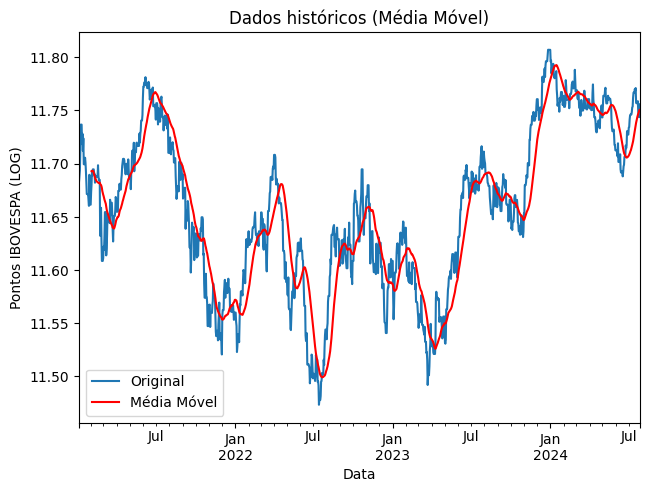

In [ ]:
df_log = np.log(df.Close)
ma_log = df_log.rolling(30).mean()

f,ax = plt.subplots()
df_log.plot(ax=ax, legend=False, label='Original')
ma_log.plot(ax=ax, legend=False, color='r', label= 'Média Móvel')
plt.tight_layout()
plt.title('Dados históricos (Média Móvel)')
plt.ylabel('Pontos IBOVESPA (LOG)', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.legend()
plt.show()

<div style="text-align: justify;">
<p style="font-size: 17px;">Vamos subtrair os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos. (Aqui buscamos isolar os padrões sazonais ou os componentes residuais.)</p>
</div>

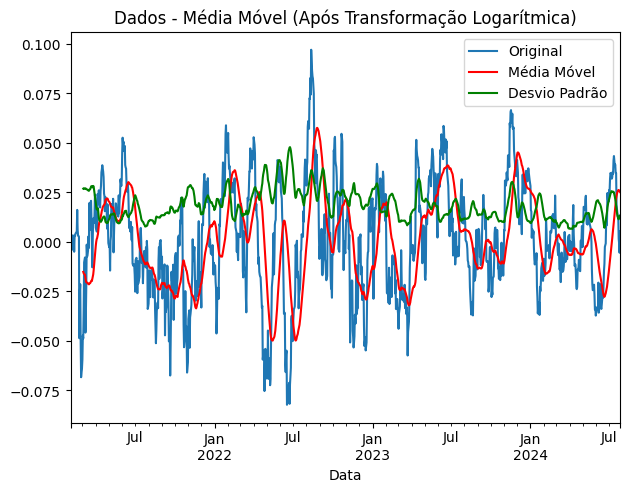

Teste ADF
Teste Estatistico: -6.024643621555
P-Value: 1.465799540417321e-07
Valores criticos
	1%:-3.435509501237317
	5%:-2.86381847140403
	10%:-2.5679830801661603

Série Estacionária


In [ ]:
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(30).mean()
std = df_s.rolling(30).std()

f,ax = plt.subplots()
df_s.plot(ax=ax, legend=False, label='Original')
ma_s.plot(ax=ax, legend=False, color='r', label='Média Móvel')
std.plot(ax=ax, legend=False, color='g', label='Desvio Padrão')
plt.tight_layout()
plt.title('Dados - Média Móvel (Após Transformação Logarítmica)')
plt.xlabel('Data', fontsize=10)
plt.legend()
plt.show()

X_s = df_s.values
result_s = adfuller(X_s)

print('Teste ADF')
print(f"Teste Estatistico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores criticos")

for key, value in result_s[4].items():
  print(f'\t{key}:{value}')
print('')
if result_s[1] < 0.05:
  print('Série Estacionária')
else:
  print('Série Não Estacionária')

<div style="text-align: justify;">
<p style="font-size: 17px;">Note que com a transformações aplicadas acima, concluímos através do teste estatístico que nossa série temporal agora é estacionária. Porém, ainda é possível deixar a série ainda mais estacionária aplicando o método de diff para remover a tendência. Vamos realizar esse procedimento abaixo</p>
</div>

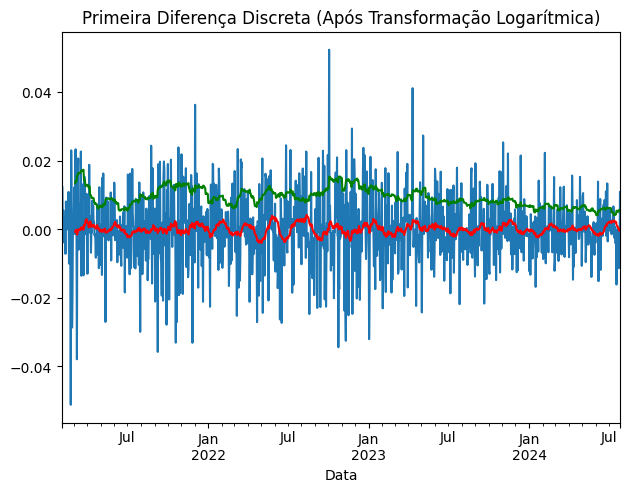

Teste ADF
Teste Estatistico: -36.36520827649926
P-Value: 0.0
Valores criticos
	1%:-3.435509501237317
	5%:-2.86381847140403
	10%:-2.5679830801661603

Série Estacionária


In [ ]:
df_diff = df_s.diff(1)

ma_diff = df_diff.rolling(30).mean()

std_diff = df_diff.rolling(30).std()

f,ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()
plt.title('Primeira Diferença Discreta (Após Transformação Logarítmica)')
plt.xlabel('Data', fontsize=10)
plt.show()

X_diff = df_diff.dropna().values
result_diff = adfuller(X_diff)

print('Teste ADF')
print(f"Teste Estatistico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores criticos")

for key, value in result_s[4].items():
  print(f'\t{key}:{value}')

print('')
if result_s[1] < 0.05:
  print('Série Estacionária')
else:
  print('Série Não Estacionária')

<div style="text-align: justify;"><p style="font-size: 17px;">Podemos observar que o valor estatístico do teste ADF (-36.365) é significativamente mais negativo do que o valor do teste anterior (-6.025), indicando uma evidência muito mais forte contra a hipótese nula de não estacionaridade. Além disso, o valor p é 0.0, reforçando ainda mais a estacionaridade da série.</p>
</div>

In [ ]:
df_diff_2 = pd.DataFrame(df_diff)
df_model_stat = df_diff_2[['Close']].copy()
df_model_stat.reset_index(inplace=True)
df_model_stat = df_model_stat.rename(columns={'Date':'ds', 'Close':'y'})
df_model_stat['unique_id'] = 'IBOVESPA'
last_date = df_model_stat['ds'].max()

<div style="text-align: justify;">
<p style="font-size: 17px;">Com isso, temos nossa base de dados (df_model), que foi padronizada para incluir um índice, uma coluna de data chamada ds, uma coluna com nossa variável alvo (y) e o unique_id. Além disso, criamos uma segunda base de dados (df_model_stat) seguindo a mesma estrutura, mas com a série temporal já transformada para ser estacionária. Utilizaremos essas bases conforme a necessidade de cada modelo, garantindo que os dados estejam adequados para as diferentes abordagens de análise e previsão.</p>
</div>

## **3. Análise exploratória dos Dados**


<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Decomposição Sazonal</b></p>

<p style="font-size: 17px;">A função Seasonal Decompose é uma técnica valiosa que aplica os dados coletados para desmembrar uma série temporal em seus componentes essenciais: tendência, sazonalidade e ruído. A tendência nos fornece insights sobre a trajetória geral da série, evidenciando se há um movimento ascendente ou descendente ao longo do tempo. A sazonalidade expõe padrões que se repetem em intervalos regulares, refletindo influências periódicas que podem afetar a série. Já o ruído representa as flutuações aleatórias que restam após a extração dos componentes de tendência e sazonalidade, capturando a variabilidade inexplicada.

Vamos empregar essa função para obter uma visão mais clara dos dados e do seu comportamento. Essa análise nos permitirá tomar decisões informadas sobre qual modelo estatístico ou de aprendizado de máquina é mais adequado para prever o comportamento futuro do IBOVESPA. A compreensão detalhada desses elementos é importante para a seleção de um modelo robusto e confiável.</p>
</div>

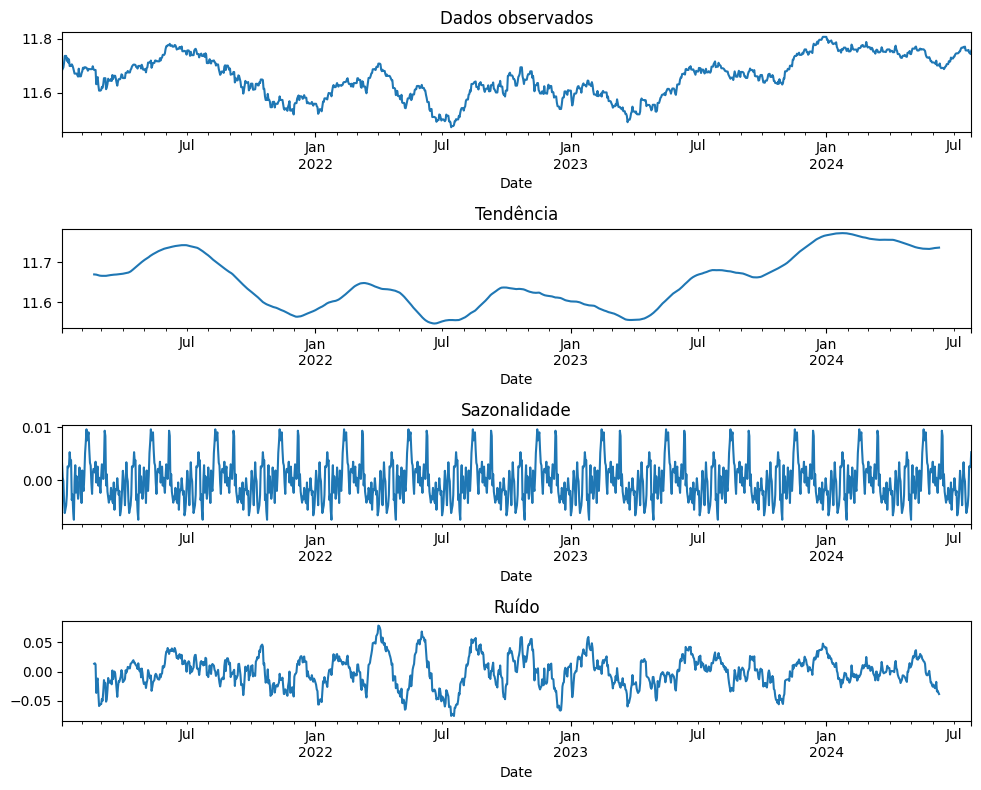

In [ ]:
df_log = df[['Close']].copy()
df_log = np.log(df_log.Close)

sd_resultados = seasonal_decompose(df_log, model='additive', period=92)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,8))

sd_resultados.observed.plot(ax=ax1)
ax1.set_title("Dados observados")

sd_resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

sd_resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

sd_resultados.resid.plot(x=ax4)
ax4.set_title("Ruído")

plt.tight_layout()

<div style="text-align: justify;">
<p style="font-size: 17px;">Com os gráficos gerados acima, observamos que a tendência do IBOVESPA é de crescimento ao longo dos últimos anos. Quanto à sazonalidade, considerando um período sazonal de um trimestre (92 dias) — escolhido por ser um intervalo em que o mercado de ações é sensível às decisões e ações do banco central e à economia brasileira, que frequentemente apresentam alterações nesse período de tempo —, identificamos muitas oscilações. Essas oscilações podem ser úteis na definição de parâmetros para modelos de predição. Por fim, os ruídos analisados não indicam oscilações significativas, o que se deve à ausência de eventos que poderiam gerar picos notáveis no IBOVESPA. Tal fato está associado ao período selecionado para nossa base de dados, que exclui dados de períodos de crise anteriormente mencionados.</p>
</div>

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Teste de Autocorrelação dos Dados</b></p>
<p style="font-size: 17px;">Ao trabalhar com modelos de séries temporais, uma etapa importante é entender a autocorrelação presente nos dados. A autocorrelação refere-se à correlação de uma série temporal com uma versão atrasada de si mesma. Para entender e visualizar essa autocorrelação, utilizamos as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).</p>

<ul class="bullet-list" style="font-size: 17px;"><li>ACF (Autocorrelação): Mostra a correlação direta e indireta.</li>
<li>PACF (Autocorrelação Parcial): Mostra apenas a correlação direta.</li></ul>

<p style="font-size: 17px;">A ACF é uma ferramenta valiosa para entender padrões de dependência temporal nos dados. Cada ponto no gráfico indica a correlação entre a série temporal e ela mesma em diferentes pontos no passado.</p>

<p style="font-size: 17px;">A PACF, por outro lado, ajuda a identificar a correlação direta entre a série temporal e seus lags, removendo os efeitos das correlações intermediárias. Isso permite uma análise mais precisa das relações diretas entre os valores da série temporal em diferentes momentos.</p>

</div>

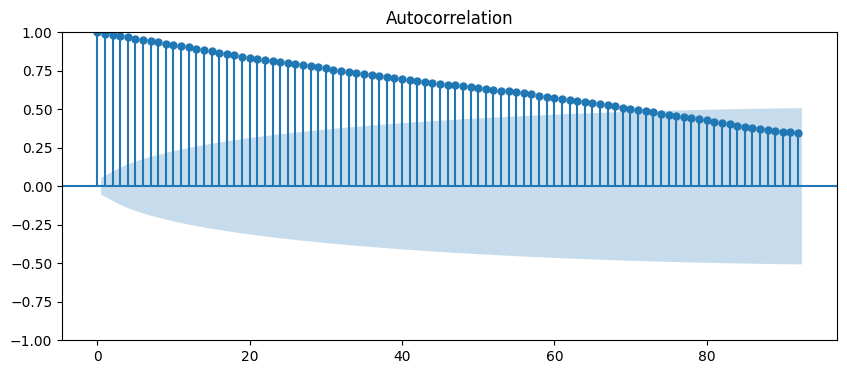

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df.Close, lags=92, ax=ax)
plt.show()

<div style="text-align: justify;">
<p style="font-size: 17px;">O intervalo de confiança por padrão é 95%, mostrado como essa marca em azul. Observações que estão para fora da marca são consideradas estatisticamente correlacionadas.</p>

<p style="font-size: 17px;">A interpretação do ACF geralmente envolve identificar padrões significativos de autocorrelação nos lags. Um lag é o intervalo de tempo entre um valor da série temporal e um valor anterior. Se a autocorrelação em um determinado lag for significativa (por exemplo, ultrapassando as linhas que indicam intervalos de confiança), isso sugere uma possível sazonalidade ou padrão repetitivo nos dados.</p>
</div>

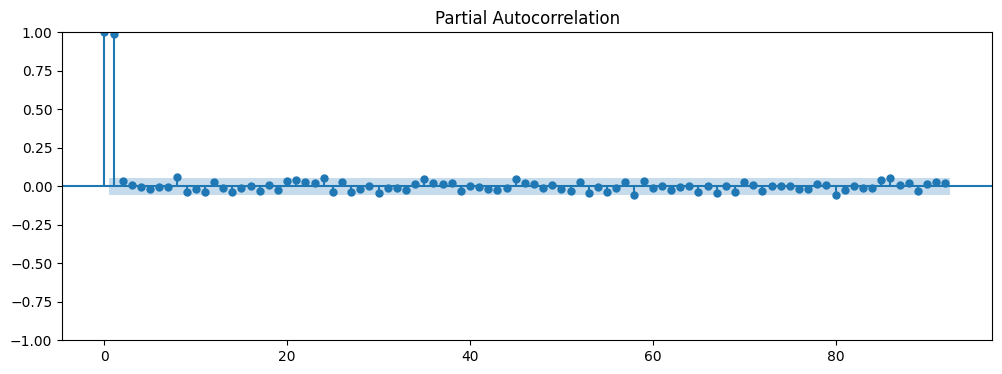

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(df.Close, lags=92, ax=ax)
plt.show()

<div style="text-align: justify;">
<p style="font-size: 17px;">A interpretação do PACF está relacionada à identificação dos lags específicos que contribuem para a autocorrelação em um determinado ponto. Em outras palavras, o PACF ajuda a determinar a ordem de defasagem apropriada para um modelo AR (autoregressivo). Neste caso, podemos observar no gráfico acima que a ordem de defasagem da série é identificada em 2 lags, indicando que os dois primeiros lags têm uma correlação significativa com os valores atuais da série.</p>
</div>

<div style="text-align: justify;">
<p style="font-size: 17px;">Abaixo estamos analisando a autocorrelação e a autocorrelação parcial de uma série temporal diferenciada (nossa segunda série temporal onde normalizamos os dados e aplicamos o diff() na sessão 2 de tratamento de dados acima).</div></p>

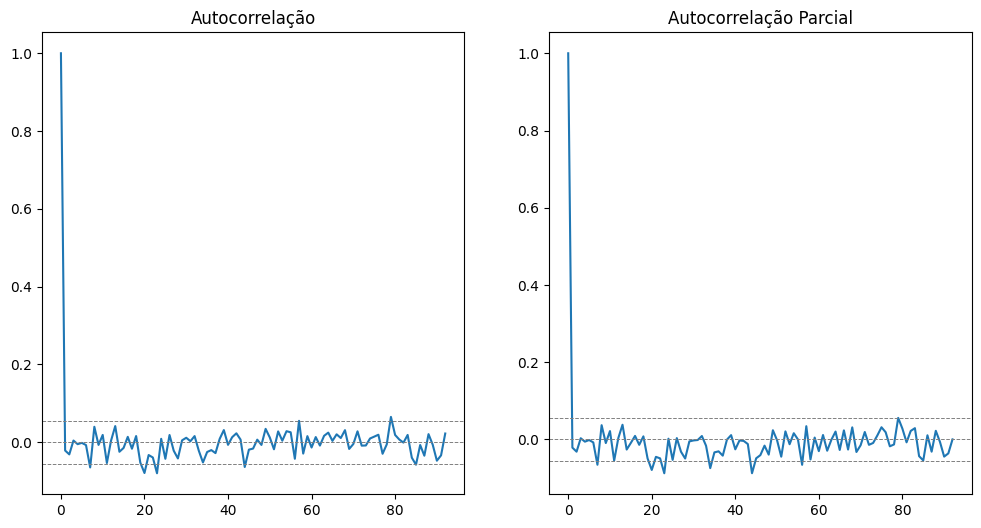

In [ ]:
lag_acf = acf(df_diff.dropna(), nlags=92)
lag_pacf = pacf(df_diff.dropna(), nlags=92)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(lag_acf)
ax1.axhline(y=-1.96/np.sqrt(len(df_diff)-1), linestyle='--', color='gray', linewidth=0.7)
ax1.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax1.axhline(y=1.96/np.sqrt(len(df_diff)-1), linestyle='--', color='gray', linewidth=0.7)
ax1.set_title('Autocorrelação')

ax2.plot(lag_pacf)
ax2.axhline(y=-1.96/np.sqrt(len(df_diff)-1), linestyle='--', color='gray', linewidth=0.7)
ax2.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax2.axhline(y=1.96/np.sqrt(len(df_diff)-1), linestyle='--', color='gray', linewidth=0.7)
ax2.set_title('Autocorrelação Parcial')

plt.show()

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>ACF:</b> Mostra a correlação entre a série temporal e seus próprios valores passados em diferentes lags. A curva toca a linha y=0 em x=2, isso indica que a autocorrelação significativa se estende até o segundo lag. Isso pode sugerir a presença de padrões sazonais ou repetitivos nos dados.</p>

<p style="font-size: 17px;"><b>PACF:</b> Mostra a correlação direta entre a série temporal e seus lags, removendo os efeitos das correlações intermediárias. A curva toca a linha y=0 em x=2, isso indica que apenas os dois primeiros lags têm uma correlação direta significativa com os valores atuais da série.</p>
</div>

<div style="text-align: justify;">
<p style="font-size: 17px;">Essas análises são fundamentais para configurar corretamente alguns modelos de séries temporais, como o ARIMA, garantindo que os parâmetros escolhidos reflitam os padrões e dependências presentes nos dados. Isso melhora a precisão das previsões e a eficácia dos modelos.</p>
</div>

## **4. Treinando e Avaliando Modelos**

<div style="text-align: justify;">
<p style="font-size: 17px;">A seguir faremos o treinamento e avaliação de uma variedade de modelos de aprendizado de máquina, incluindo o Naive, Seasonal Naive, Seasonal Window Average, ARIMA, Prophet e XGBoost. O propósito é determinar qual desses modelos harmoniza melhor com nossos dados históricos, visando otimizar a precisão das previsões futuras.</p>

<p style="font-size: 17px;">Consideramos que um modelo é eficiente quando demonstra um baixo índice de erro, conforme avaliado por uma combinação específica de métricas:</p>

<ul class="bullet-list" style="font-size: 17px;"><li><b>Mean Average Error (MAE):</b> Representa a média das diferenças absolutas entre as previsões e os valores reais, sem considerar a direção dos erros.</li>

<li><b>Root Mean Square Error (RMSE):</b> Mede a raiz quadrada da média dos quadrados dos erros, o que proporciona uma medida na mesma unidade dos dados originais e penaliza mais fortemente os erros maiores.</li>

<li><b>Weighted Mean Absolute Percentage Error (WMAPE):</b> É uma medida de precisão que considera a escala dos dados.</li>

<p style="font-size: 17px;">Abaixo, criaremos um função para calcular o WMAPE. Para o MAE e o RMSE não precisaremos de funções pois o mesmos são importados da biblioteca sklearn.</p>

</div>

In [ ]:
# Função WMAPE
def calculate_wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Base de treino e validação</b></p>

<p style="font-size: 17px;">Conforme o script abaixo, definimos uma base de treino e uma base de validação. A base de treino inclui dados históricos até a data especificada. O treinamento do modelo com esses dados permite que o algoritmo aprenda as tendências, sazonalidades e padrões do índice até aquele ponto no tempo.</p>

<p style="font-size: 17px;">A base de teste (valid) é usada para avaliar a performance do modelo. Ao testar o modelo em dados que não foram usados no treinamento, podemos medir sua capacidade de generalização e prever dados futuros. O número de dias únicos (h) representa um trimestre, que é um período relevante para análise financeira. As decisões do banco central e mudanças na economia brasileira dentro desse intervalo podem afetar significativamente o mercado de ações.</p>
</div>

In [ ]:
# Base de treino e validação (Série Não Estacionária)
treino = df_model.loc[df_model['ds'] < '2024-03-31']
valid = df_model.loc[(df_model['ds'] >= '2024-03-31') & (df_model['ds'] <= '2024-06-30')]
h = valid['ds'].nunique()

In [ ]:
# Base de treino (Série Estacionária)
treino_stat = df_model_stat.loc[df_model_stat['ds'] < '2024-03-31']

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Modelos:</b> Naive, SeasonalNaive e SeasonalWindowAverage</p>

<p style="font-size: 17px;">O objeto <b>model_a</b> abaixo é uma composição dos seguintes modelos de aprendizado de máquina: Naive, SeasonalNaive e SeasonalWindowAverage. Cada um dos modelos contribui com uma perspectiva única para a previsão da série temporal da IBOVESPA:

<ul class="bullet-list" style="font-size: 17px;"><li><b>Naive():</b> Este modelo serve como uma referência simples, assumindo que o valor de fechamento de um dia será o mesmo do dia anterior.

<li><b>SeasonalNaive(season_length=92):</b> Adapta o modelo para considerar a sazonalidade, utilizando o padrão do mesmo dia em ciclos anteriores de 92 dias para fazer previsões.</li>

<li><b>SeasonalWindowAverage(season_length=92, window_size=10):</b> Calcula a média dos valores em uma janela de tempo definida para suavizar a série e prever tendências, levando em conta a sazonalidade trimestral.</li>

<li><b>ConformalIntervals(90):</b> Define um intervalo de confiança para as previsões, indicando a probabilidade de que os valores previstos estejam dentro de uma margem de erro aceitável.</li>

<li><b>freq=‘D’:</b> Estabelece que os dados são coletados e previstos diariamente, alinhando o modelo com a frequência dos dados da IBOVESPA.</li>

<li><b>n_jobs=-1:</b> Permite que o modelo utilize todos os núcleos do processador disponíveis para otimizar o tempo de treinamento.</li></ul>

<p style="font-size: 17px;">Ao combinar esses elementos, obtemos todas previsões dentro do mesmo objeto. Com isso, podemos entender a dinâmica das previsões de cada modelo para o mercado de ações brasileiro.</p>
</div>

In [ ]:
# Naive, SeasonalNaive, SeasWA
model_a = StatsForecast(models=[Naive(), SeasonalNaive(season_length=92),SeasonalWindowAverage(season_length=92, window_size=10, prediction_intervals=ConformalIntervals(90))], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Modelo:</b> ARIMA</p>

<p style="font-size: 17px;">O ARIMA (AutoRegressive Integrated Moving Average) é um modelo de previsão para séries temporais que combina três componentes: autoregressão (AR), diferenciação (I) e média móvel (MA). É amplamente utilizado para modelar e prever dados de séries temporais, especialmente quando os dados apresentam padrões de tendência e sazonalidade.</p>

<p style="font-size: 17px;">O modelo abaixo foi treinado com os mesmos dados históricos que utilizamos em modelos anteriores, <b>porém com uma série estacionária, pois é um pré-requisito do ARIMA</b>, e estamos realizando uma previsão considerando um período trimestral.</p>

<p style="font-size: 17px;">Hiperparâmetros do algortimo:</p>
<ul class="bullet-list" style="font-size: 17px;">
<li>P - Número de lags que devem ser incluídos no modelo (lags são valores auto correlacionados que devem ser levados em consideração, ou seja, os valores históricos que serão utilizados para prever o futuro).</li>
<li>D - Número de vezes que as observações serão diferenciadas. (tornar a série estacionária).</li>
<li>Q - Ordem de média móvel, tamanho de uma janela (lag) de média móvel.(para calcular o erro e encontrar a melhor previsão (tamanho da janela da media móvel) para calcular os residuos e fazer o forecast).</li></ul>

<p style="font-size: 17px;">No nosso projeto, o modelo ARIMA foi configurado com os parâmetros "p" igual a 2, "d" igual a 1 e "q" igual a 2. Isso significa que, para ajustar o modelo à série temporal, definimos "p" como 2, indicando que o modelo considera os dois períodos anteriores da série para fazer a previsão atual. O parâmetro "d" foi definido como 1, o que implica que aplicamos uma diferenciação simples à série para torná-la estacionária e remover possíveis tendências, garantindo que as propriedades estatísticas da série sejam constantes ao longo do tempo. Por fim, "q" foi configurado como 2, o que significa que o modelo leva em conta os dois períodos anteriores dos resíduos da previsão para melhorar o ajuste do modelo. Esse conjunto de parâmetros foi escolhido para capturar de forma eficaz a estrutura temporal da série e melhorar a precisão das nossas previsões. A série temporal utilizada foi previamente tratada para ser estacionária, o que é essencial para a aplicação eficaz do modelo ARIMA. Detalhes sobre estacionariedade e autocorrelação, que foram importantes na preparação da série temporal e na definição dos parâmetros "p", "d" e "q" do modelo, podem ser encontrados nos tópicos 2, que refere-se do Tratamento de Dados, e 3, que aborda a Análise Exploratória, deste documento.</p>
</div>

In [ ]:
# ARIMA
model_b = StatsForecast(models=[ARIMA(order=(2, 1, 2))],freq='D',n_jobs=-1) # P, D, Q -> order=(2, 1, 2)
model_b.fit(treino_stat)

forecast_df_arima = model_b.predict(h = h, level=[90])
forecast_df_arima = forecast_df_arima.reset_index()
forecast_df_arima['unique_id'] = 'IBOVESPA'

forecast_df_arima = forecast_df_arima.merge(valid, on=['ds', 'unique_id'], how='left')

In [ ]:
filtered_log = df_log[(df_log.index >= '2024-03-31') & (df_log.index <= '2024-06-30')]
forecast_df_arima['ARIMA_rev_diff'] = filtered_log.iloc[0] + forecast_df_arima['ARIMA'].cumsum()
forecast_df_arima['ARIMA_rev_log'] = np.exp(forecast_df_arima['ARIMA_rev_diff'])

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Modelo:</b> Prophet</p>

<p style="font-size: 17px;">O Prophet é um modelo de previsão para séries temporais desenvolvido pelo Facebook, que é robusto a dados faltantes e mudanças de tendência, e normalmente funciona bem com sazonalidades diárias, semanais e anuais.</p>

<p style="font-size: 17px;">O modelo abaixo foi treinado com os mesmos dados históricos que utilizamos em modelos anteriores e estamos realizando uma previsão considerando um período trimestral conforme definido no parâmetro "periods" do ".make_future_dataframe"</p>
</div>

In [ ]:
# Prophet
prophet_object = Prophet(interval_width=0.9)
prophet_object.fit(treino)
df_future = prophet_object.make_future_dataframe(periods=92)
df_forecast = prophet_object.predict(df_future)
forecast_prophet = df_forecast.merge(df_model, on=['ds'], how='left')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps3u8d1qp/oeqi8b3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps3u8d1qp/tp8ez1_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60038', 'data', 'file=/tmp/tmps3u8d1qp/oeqi8b3t.json', 'init=/tmp/tmps3u8d1qp/tp8ez1_o.json', 'output', 'file=/tmp/tmps3u8d1qp/prophet_model0imo6zru/prophet_model-20240729125434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Modelo:</b> XGBoost</p>

<p style="font-size: 17px;">O XGBoost é um modelo de aprendizado de máquina para previsões precisas, que treina com características temporais (ano, mês, dia, dia da semana) e utiliza árvores de decisão para minimizar o erro quadrado nas previsões</p>
<p style="font-size: 17px;">O modelo abaixo foi treinado com os mesmos dados históricos que utilizamos em modelos anteriores e estamos realizando uma previsão considerando um período trimestral conforme definido na nossa base de treino a validação anteriormente.</p>

</div>

In [ ]:
# XBoost
def create_features(df):
  df['ds'] = pd.to_datetime(df['ds'])
  df['year'] = df['ds'].dt.year
  df['month'] = df['ds'].dt.month
  df['day'] = df['ds'].dt.day
  df['dayofweek'] = df['ds'].dt.dayofweek
  return df

treino_xgboost = create_features(treino)
valid_xgboost = create_features(valid)

FEATURES = ['year', 'month', 'day', 'dayofweek']
TARGET = 'y'

x_train, y_train = treino_xgboost[FEATURES], treino_xgboost[TARGET]
x_test, y_test = valid_xgboost[FEATURES], valid_xgboost[TARGET]

reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(x_train,y_train)

valid_xgboost['xgboost_forecast'] = reg.predict(x_test)

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Avaliando a precisão dos modelos com as métricas MAE, RMSE e WMAPE</b></p>

<p style="font-size: 17px;">A seguir, vamos aplicar métricas específicas — MAE, RMSE, e WMAPE — para avaliar e comparar a performance dos modelos preditivos que treinamos. Dado que todos foram ajustados com o mesmo conjunto de dados de treino e projetados para prever a mesma quantidade de pontos, esta etapa é importante para determinar qual modelo se destaca em termos de precisão e confiabilidade.</p>

</div>

In [ ]:
# Calculando MAE
mae_model1 = round(np.log(mean_absolute_error(forecast_dfa['y'], forecast_dfa['Naive'])),2)
mae_model2 = round(np.log(mean_absolute_error(forecast_dfa['y'], forecast_dfa['SeasonalNaive'])),2)
mae_model3 = round(np.log(mean_absolute_error(forecast_dfa['y'], forecast_dfa['SeasWA'])),2)
mae_model4 = round(np.log(mean_absolute_error(forecast_df_arima['y'], forecast_df_arima['ARIMA_rev_log'])),2)
mae_model5 = round(np.log(mean_absolute_error(forecast_prophet['y'], forecast_prophet['yhat'])),2)
mae_model6 = round(np.log(mean_absolute_error(valid_xgboost['y'], valid_xgboost['xgboost_forecast'])),2)

mae_values = {'Model': ['Naive', 'SeasonalNaive', 'SeasWA', 'ARIMA', 'Prophet', 'XGBoost'],'MAE': [mae_model1, mae_model2, mae_model3, mae_model4, mae_model5, mae_model6]}
mae_df = pd.DataFrame(mae_values).sort_values(by='MAE')

In [ ]:
# Calculando RMSE
rmse_model1 = round(np.log(np.sqrt(mean_squared_error(forecast_dfa['y'], forecast_dfa['Naive']))),2)
rmse_model2 = round(np.log(np.sqrt(mean_squared_error(forecast_dfa['y'], forecast_dfa['SeasonalNaive']))),2)
rmse_model3 = round(np.log(np.sqrt(mean_squared_error(forecast_dfa['y'], forecast_dfa['SeasWA']))),2)
rmse_model4 = round(np.log(np.sqrt(mean_squared_error(forecast_df_arima['y'], forecast_df_arima['ARIMA_rev_log']))),2)
rmse_model5 = round(np.log(np.sqrt(mean_squared_error(forecast_prophet['y'], forecast_prophet['yhat']))),2)
rmse_model6 = round(np.log(np.sqrt(mean_squared_error(valid_xgboost['y'], valid_xgboost['xgboost_forecast']))),2)

rmse_values = {'Model': ['Naive', 'SeasonalNaive', 'SeasWA', 'ARIMA', 'Prophet', 'XGBoost'],'RMSE': [rmse_model1, rmse_model2, rmse_model3, rmse_model4, rmse_model5, rmse_model6]}
rmse_df = pd.DataFrame(rmse_values).sort_values(by='RMSE')

In [ ]:
# Calculando WMAPE
wmape_model1 = calculate_wmape(forecast_dfa['y'], forecast_dfa['Naive'])
wmape_model2 = calculate_wmape(forecast_dfa['y'], forecast_dfa['SeasonalNaive'])
wmape_model3 = calculate_wmape(forecast_dfa['y'], forecast_dfa['SeasWA'])
wmape_model4 = calculate_wmape(forecast_df_arima['y'], forecast_df_arima['ARIMA_rev_log'])
wmape_model5 = calculate_wmape(forecast_prophet['y'], forecast_prophet['yhat'])
wmape_model6 = calculate_wmape(valid_xgboost['y'], valid_xgboost['xgboost_forecast'])

wmape_values = {'Model': ['Naive', 'SeasonalNaive', 'SeasWA', 'ARIMA', 'Prophet', 'XGBoost'],'WMAPE': [wmape_model1, wmape_model2, wmape_model3, wmape_model4, wmape_model5, wmape_model6]}
wmape_df = pd.DataFrame(wmape_values).sort_values(by='WMAPE')

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Representação em gráfico da avaliação dos modelos</b></p>
<p style="font-size: 17px;">Para uma visualização clara e intuitiva, apresentamos um gráfico que compara a eficácia dos modelos preditivos, utilizando uma escala logarítmica para facilitar o entendimento dos resultados da análise.</p>

</div>

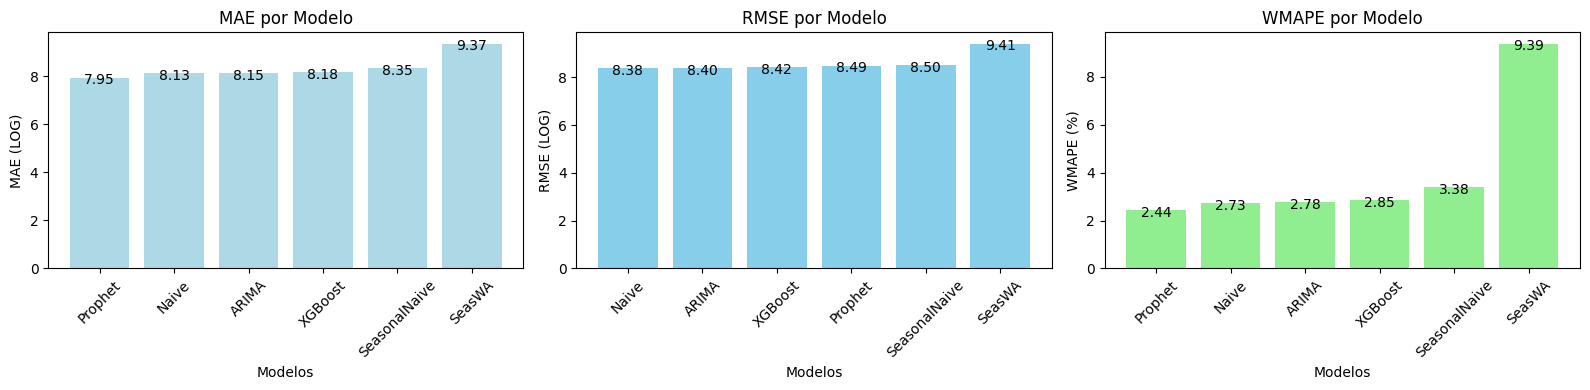

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Plotando MAE
mae_bars = axs[0].bar(mae_df['Model'], mae_df['MAE'], color='lightblue')
axs[0].set_title('MAE por Modelo')
axs[0].set_ylabel('MAE (LOG)')
axs[0].set_xlabel('Modelos')
axs[0].set_xticklabels(mae_df['Model'], rotation=45)

# Adicionando os valores dentro das barras para MAE
for bar in mae_bars:
    height = bar.get_height()
    axs[0].annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='top')

# Plotando RMSE
mae_bars = axs[1].bar(rmse_df['Model'], rmse_df['RMSE'].sort_values(), color='skyblue')
axs[1].set_title('RMSE por Modelo')
axs[1].set_ylabel('RMSE (LOG)')
axs[1].set_xlabel('Modelos')
axs[1].set_xticklabels(rmse_df['Model'], rotation=45)

# Adicionando os valores dentro das barras para RMSE
for bar in mae_bars:
    height = bar.get_height()
    axs[1].annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='top')

# Plotando WMAPE
wmape_bars = axs[2].bar(wmape_df['Model'], wmape_df['WMAPE'].sort_values(), color='lightgreen')
axs[2].set_title('WMAPE por Modelo')
axs[2].set_ylabel('WMAPE (%)')
axs[2].set_xlabel('Modelos')
axs[2].set_xticklabels(wmape_df['Model'], rotation=45)

# Adicionando os valores dentro das barras para WMAPE
for bar in wmape_bars:
    height = bar.get_height()
    axs[2].annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='top')
plt.tight_layout()
plt.show()

<div style="text-align: justify;">
<p style="font-size: 17px;"><b>Análise dos resultados obtidos pelas métricas de erro</b></p>
<p style="font-size: 17px;">Com base nos resultados obtidos pelas métricas de erro, observamos que o modelo Prophet se destacou, apresentando a melhor performance segundo as métricas MAE e WMAPE. Por outro lado, os modelos Naive, ARIMA e XGBoost exibiram resultados superiores no que diz respeito ao RMSE. Contudo, é importante notar que o modelo Naive baseia suas previsões unicamente no último dado observado na série histórica, o que pode limitar sua aplicabilidade em contextos mais complexos.</p>
<p style="font-size: 17px;">O modelo ARIMA foi configurado com parâmetros ( p = 2 ), ( d = 1 ) e ( q = 2 ) e foi treinado com a série temporal estacionária disponível. Apesar de ter registrado um desempenho relativamente bom no RMSE, o ARIMA não teve o mesmo sucesso nas métricas MAE e WMAPE. Isso indica que, enquanto o modelo pode ser eficaz em minimizar erros quadráticos médios, suas previsões não foram tão precisas em termos absolutos e percentuais quando comparadas às do Prophet. Esta discrepância sugere que o ARIMA pode ter limitações na captura de padrões mais sutis da série temporal, afetando negativamente a precisão e a robustez das previsões.</p>
<p style="font-size: 17px;">O XGBoost também apresentou um RMSE mais baixo em comparação ao Prophet, mas não atingiu a mesma eficácia nas métricas de MAE e WMAPE. Isso demonstra que, embora o XGBoost possa ser forte em termos de erro quadrático médio, ele não oferece a mesma precisão e robustez geral nas previsões.</p>
<p style="font-size: 17px;">Com base na análise abrangente das métricas de erro — MAE, RMSE e WMAPE — e considerando as características específicas de cada modelo, concluímos que o Prophet é o modelo mais adequado para ser escolhido. Ele demonstrou um equilíbrio superior em termos de precisão e robustez, conforme evidenciado por seu desempenho nas métricas selecionadas. Embora outros modelos tenham mostrado pontos fortes em métricas individuais, o Prophet ofereceu a melhor performance geral, tornando-o a escolha ideal para prever os pontos do IBOVESPA no contexto atual da nossa série temporal.</p>
</div>

## **5. Modelo escolhido**

<div style="text-align: justify;">
<p style="font-size: 17px;">Apresentamos a seguir um gráfico de dispersão (scatterplot) que ilustra a performance do modelo Prophet. Este gráfico destaca os pontos observados dos dados históricos, as previsões realizadas pelo modelo e os intervalos de confiança associados a essas previsões. A visualização gráfica é uma ferramenta poderosa, pois facilita a compreensão do comportamento do modelo e a precisão de suas previsões em relação aos dados reais.</p>
</div>

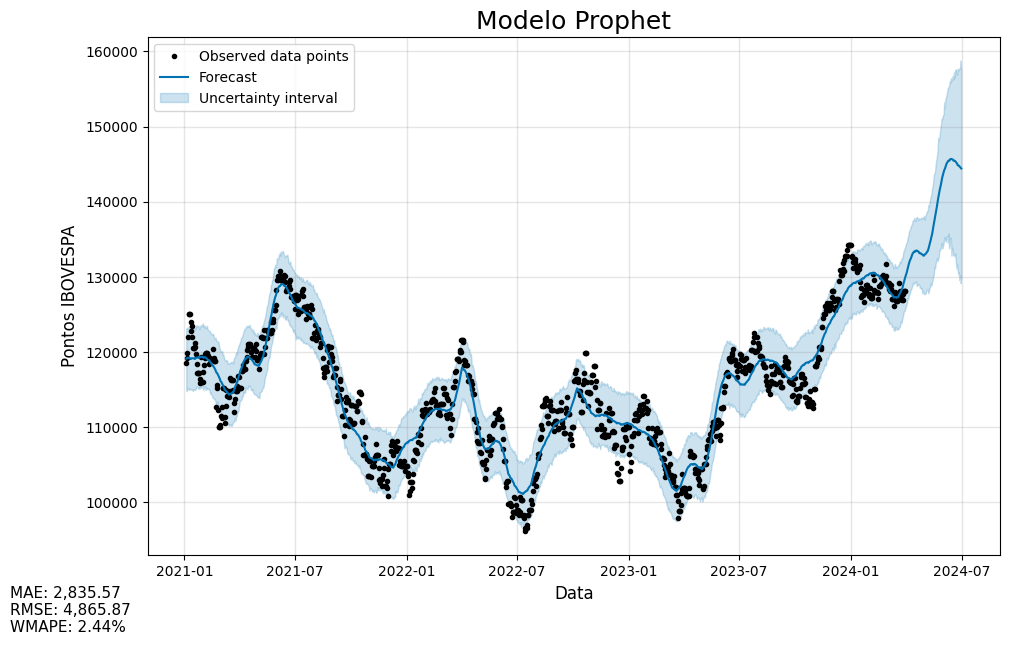

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7))
plt.subplots_adjust(top=0.85)
prophet_object.plot(forecast_prophet, ax=ax)

plt.legend(loc='upper left')
plt.title('Modelo Prophet', fontsize=18)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Pontos IBOVESPA', fontsize=12)

metrics_text = f"MAE: {math.exp(mae_model5):,.2f}\nRMSE: {math.exp(rmse_model5):,.2f}\nWMAPE: {wmape_model5:,.2f}%"

plt.figtext(0, 0, metrics_text, horizontalalignment='left', fontsize=11)

plt.show()

# **Conclusão**

<div style="text-align: justify;">
<p style="font-size: 17px;">Após uma análise detalhada e criteriosa dos diferentes modelos de aprendizado de máquina aplicados à série temporal da IBOVESPA, chegamos a uma conclusão sobre o modelo mais eficaz para prever o fechamento diário do índice. O modelo Prophet, demonstrou ser o mais adequado para a tarefa, superando os demais modelos em termos de precisão e robustez, conforme avaliado pelas métricas MAE e WMAPE.</p>

<p style="font-size: 17px;">Embora modelos como o Naive, ARIMA e XGBoost tenham apresentado pontos fortes em métricas individuais, como o RMSE, o Prophet destacou-se por sua capacidade de equilibrar a precisão em todas as métricas consideradas. Este modelo provou ser robusto a dados faltantes e mudanças de tendência, além de lidar bem com sazonalidades, um aspecto crucial para a previsão de índices de mercado de ações.</p>

<p style="font-size: 17px;">Ao considerar o desempenho geral do modelo Prophet, observamos que ele não apenas se alinha com as tendências e padrões históricos do IBOVESPA, mas também fornece intervalos de confiança, que são essenciais para a tomada de decisões informadas no mercado de ações. A visualização gráfica das previsões e dos intervalos de confiança reforça a confiabilidade do modelo, oferecendo uma representação clara da sua performance em relação aos dados reais.</p>

<p style="font-size: 17px;">Concluímos que o modelo Prophet é uma ferramenta valiosa para investidores e analistas financeiros que buscam apoio na previsão do fechamento diário do IBOVESPA. Com uma acurácia superior a 70%, o modelo não apenas atende ao objetivo inicial proposto, mas também se estabelece como um recurso decisivo para estratégias de investimento no mercado de ações brasileiro. A escolha do Prophet como modelo preditivo para a série temporal é justificada pela sua eficácia e aplicabilidade prática, assegurando uma base sólida para previsões futuras e análises de mercado.</p>
</div>

# **Referências Bibliográficas**

**Weighted Mean Absolute Percentage Error (WMAPE)** - https://www.google.com/search?q=wmape+meaning&rlz=1C1GCEW_en&oq=wmape&gs_lcrp=EgZjaHJvbWUqBggAEEUYOzIGCAAQRRg7MgYIARBFGDnSAQgyNzUwajBqOagCALACAQ&sourceid=chrome&ie=UTF-8

**Mean Average Error (MAE)** - https://en.wikipedia.org/wiki/Mean_absolute_error

**Root Mean Square Error (RMSE)** - https://en.wikipedia.org/wiki/Root_mean_square_deviation

**Naive** - https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#naive

**Seasonal Naive** - https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#seasonalnaive

**Seasonal Window Average** - https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#seasonalwindowaverage

**AutoARIMA** - https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#autoarima

**PROPHET** - https://facebook.github.io/prophet/docs/quick_start.html

**XGBoost** - https://xgboost.readthedocs.io/en/stable/parameter.html

**Predicting stock values with machine learning and deep learning algorithms** - https://medium.com/@anaraquel.fiap/predicting-stock-values-with-machine-learning-and-deep-learning-algorithms-5eb028892888